# Fetal Health Classification
## Progetto d'Esame di _Applicazioni di Data Intensive_
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

**Luca Tassinari** • **luca.tassinari10@studio.unibo.it**

## TODO

1. encoding su variabile categorica ?
3. class weight




In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [211]:
import os
from urllib.request import urlretrieve
def download(file, url):
    ''' A simple function to download, from a given url, a file. '''
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Introduzione al caso di studio
### Contesto
La riduzione della mortalità infatile è uno degli [obiettivi](https://www.eda.admin.ch/agenda2030/it/home/agenda-2030/die-17-ziele-fuer-eine-nachhaltige-entwicklung/ziel-3--ein-gesundes-leben-fuer-alle-menschen-jeden-alters-gewae.html) di sviluppo sostenibile delle Nazioni Unite e, sicuramente, uno dei grandi indicatori del progresso umano.

In questo contesto, la [cardiotocografia](https://it.wikipedia.org/wiki/Cardiotocografia) è un esame poco invasivo che viene effettuato durante il periodo prenatale e che, grazie a un trasduttore a ultrasuoni, permette di monitorare la frequenza cardiaca fetale (FHR), i movimenti fetali, le contrazioni uterine e altro ancora.

### I dati
Lo scopo è riuscire a creare un algoritmo di **classificazione** che permetta di identificare i bimbi a rischio e quelli in condizioni patologiche.
Per farlo si usa un dataset scaricato da [kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) in cui 2126 registrazioni delle caratteristiche estratte dalle cardiotocografie sono state classificate da tre ostretici esperti in 3 classi:
- Normale
- Sospetto
- Patologico

In [212]:
download("data.csv.gz", "https://github.com/tassiLuca/dia-project/raw/master/datasets/fetal_health.csv.gz")

In [213]:
data = pd.read_csv("data.csv.gz", compression="gzip")

In [214]:
# by default pandas displays only 20 cols
pd.options.display.max_columns = len(data.columns)

Vengono qui riportate le descrizioni delle 22 _feature_ del dataset:
- `baseline value`: Baseline Fetal Heart Rate (FHR);
- `accelerations`: Number of accelerations per second;
- `fetal_movement`: Number of fetal movements per second; 
- `uterine_contractions`: Number of uterine contractions per second;
- `light_decelerations`: Number of LDs per second;
- `severe_decelerations`: Number of SDs per second;
- `prolongued_decelerations`: Number of PDs per second;
- `abnormal_short_term_variability`: Percentage of time with abnormal short term variability;
- `mean_value_of_short_term_variability`: Mean value of short term variability;
- `percentage_of_time_with_abnormal_long_term_variability`: Percentage of time with abnormal long term variability;
- `mean_value_of_long_term_variability` (numerica): Mean value of long term variability;
- `histogram_width` (numerica): Width of the histogram made using all values from a record;
- `histogram_min` (numerica): Histogram minimum value;
- `histogram_max` (numerica): Histogram maximum value;
- `histogram_number_of_peaks` (numerica) : Number of peaks in the exam histogram;
- `histogram_number_of_zeroes` (numerica): Number of zeroes in the exam histogram;
- `histogram_mode` (numerica): Hist mode;
- `histogram_mean` (numerica): Hist mean;
- `histogram_median` (numerica): Hist median;
- `histogram_variance` (numerica): Hist variance;
- `histogram_tendency` (categorica): Histogram trend;
- **`fetal_health`: to predict**
    - 0: Normal
    - 1: Suspect
    - 2: Pathological

In [215]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


## Analisi esplorativa dei dati

Definiamo un dizionario per mappare le tre classi (1, 2, 3) in una descrizione più leggibile e in tre colori differenti (ci servirà più tardi per i grafici):

In [216]:
diagnosis_desc = {1.0: "normale", 2.0: "sospetto", 3.0: "patologico"}

In [217]:
diagnosis_color_map = {1.0: "green", 2.0: "orange", 3.0: "red"}

In [218]:
diagnosis_colors = data["fetal_health"].map(diagnosis_color_map)

Come si può notare tutte le _features_ del dataset sono numeriche, tranne che per `histogram_tendency` che può assumere 3 valori 0, 1 e -1:

In [219]:
data["histogram_tendency"].value_counts()

 0.0    1115
 1.0     846
-1.0     165
Name: histogram_tendency, dtype: int64

Visualizziamo la distribuzione dei dati nel dataset, attraverso un semplice grafico a torta.

In [220]:
dd = data["fetal_health"].map(diagnosis_desc).value_counts().to_frame(name="count")
dd["%"] = (dd["count"] / len(data)) * 100
dd

,count,%
normale,1655,77.845720
sospetto,295,13.875823
patologico,176,8.278457


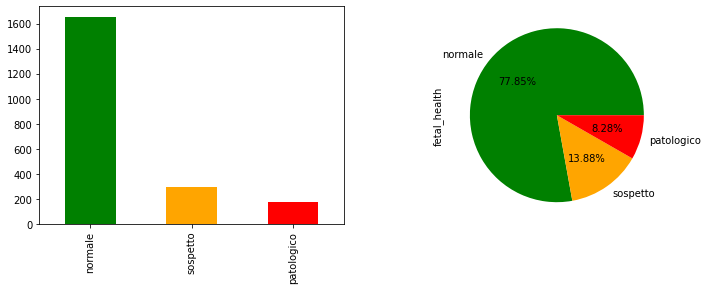

In [221]:
plt.figure(figsize=(12, 4))
data["fetal_health"].map(diagnosis_desc).value_counts().plot.bar(
    ax=plt.subplot(1, 2, 1),
    color=list(diagnosis_color_map.values())
)
data["fetal_health"].map(diagnosis_desc).value_counts().plot.pie(
    autopct="%.2f%%",
    ax=plt.subplot(1, 2, 2), 
    colors=list(diagnosis_color_map.values())
)

Come si può osservare, il 78% delle osservazioni del dataset sono state classificate come normali, il 14% come sospette e circa l'8% come patologiche. Su un totale di 2126 osservazioni, quindi, appena 176 sono state classificate come casi patologici e solo 295 come casi sospetti.

Siamo quindi in presenza di un dataset in cui la suddivisione di istanze tra le classi è molto **sbilanciata**. Questo può portare a molti più errori di classificazione sulla classe meno rappresentata - che nel caso in esame è proprio la classe più importante da predire - e a fornire stime di accuratezza fuorvianti. Per questo sarà fondamentale, nel seguito, adottare stime di accuratezza più raffinate (quali la _Precision_, _Recall_, _F1 Score_) e metodi per cercare di ridurre questo problema (come aumentare il peso degli errori sulla classe con meno istanze).

Statistiche per ogni _feature_:

In [222]:
data.iloc[:, :-1].describe()
#            ^^^^
# exclude the last col which contains the target

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


Come si può osservare dalla tabella delle statistiche aggregate delle colonne (e poi anche nel successivo _boxplot_) le variabili coinvolte utilizzano scale di valori molto diverse (ad es. `baseline value` è nell'ordine delle centinaia di unità, `accelerations` nell'ordine di centesimi di unità). Per ottenere modelli con migliore accuratezza sarà quindi necessario applicare la **standardizzazione** a tutte le variabili.

Grafichiamo con dei _boxplot_ i dati per individuare eventuali _outliers_. Si ricorda che gli estremi inferiore e superiore di ciascun rettangolo rappresentano il primo ($Q_1$) e terzo quartile ($Q_3$) (rispettivamente 25° e 75° percentile) dei dati e la linea centrale è la mediana. I cerchi molto distanti dalla mediana sono detti _outlier_: tutti quei valori $x$ t.c. $$x < Q_1 - 1,5 \cdot IQR \lor x > Q_3 + 1,5 \cdot IQR $$ dove $IQR = Q_3 - Q_1$

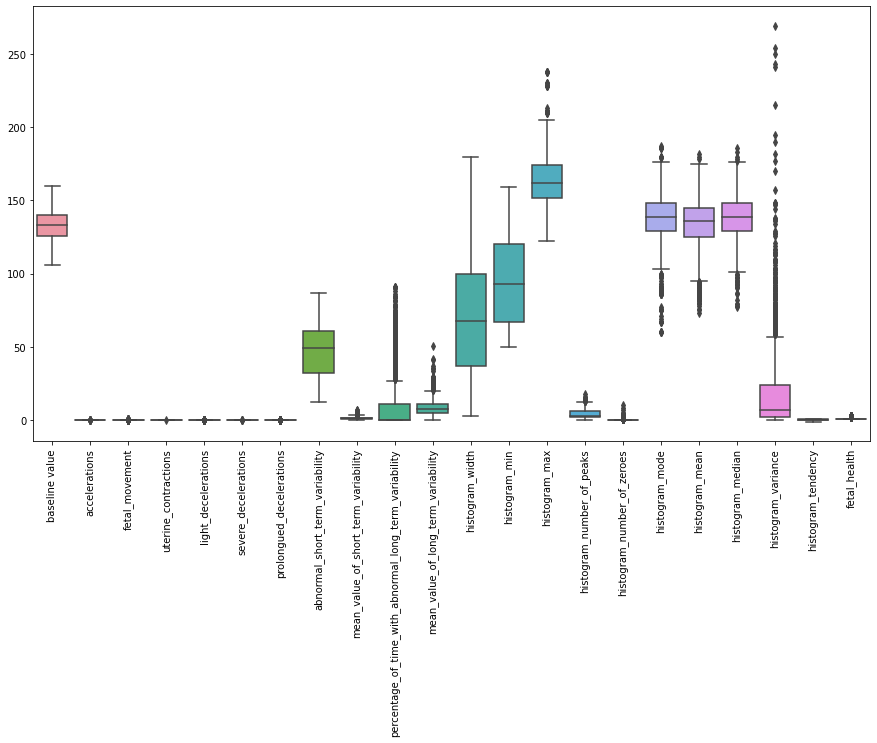

In [223]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.show()

Nonostante siano presenti valori anomali nel dataset (i.e. _outliers_), si ritiene opportuno **non** eliminarli: il dataset sopra presentato è il frutto di un rapporto CTG in cui ciascuna osservazione è stata etichettata da esperti, per cui si ritiene improbabile un errore di immissione dei dati, bensì siano proprio queste osservazioni anomale ad essere significative per il caso di studio.

Al fine di valutare quanto le variabili siano utili nella predizione grafichiamo, per ogni variabile predittiva, la distribuzione delle classi in un istogramma.

In [224]:
# data.pivot(columns="fetal_health")

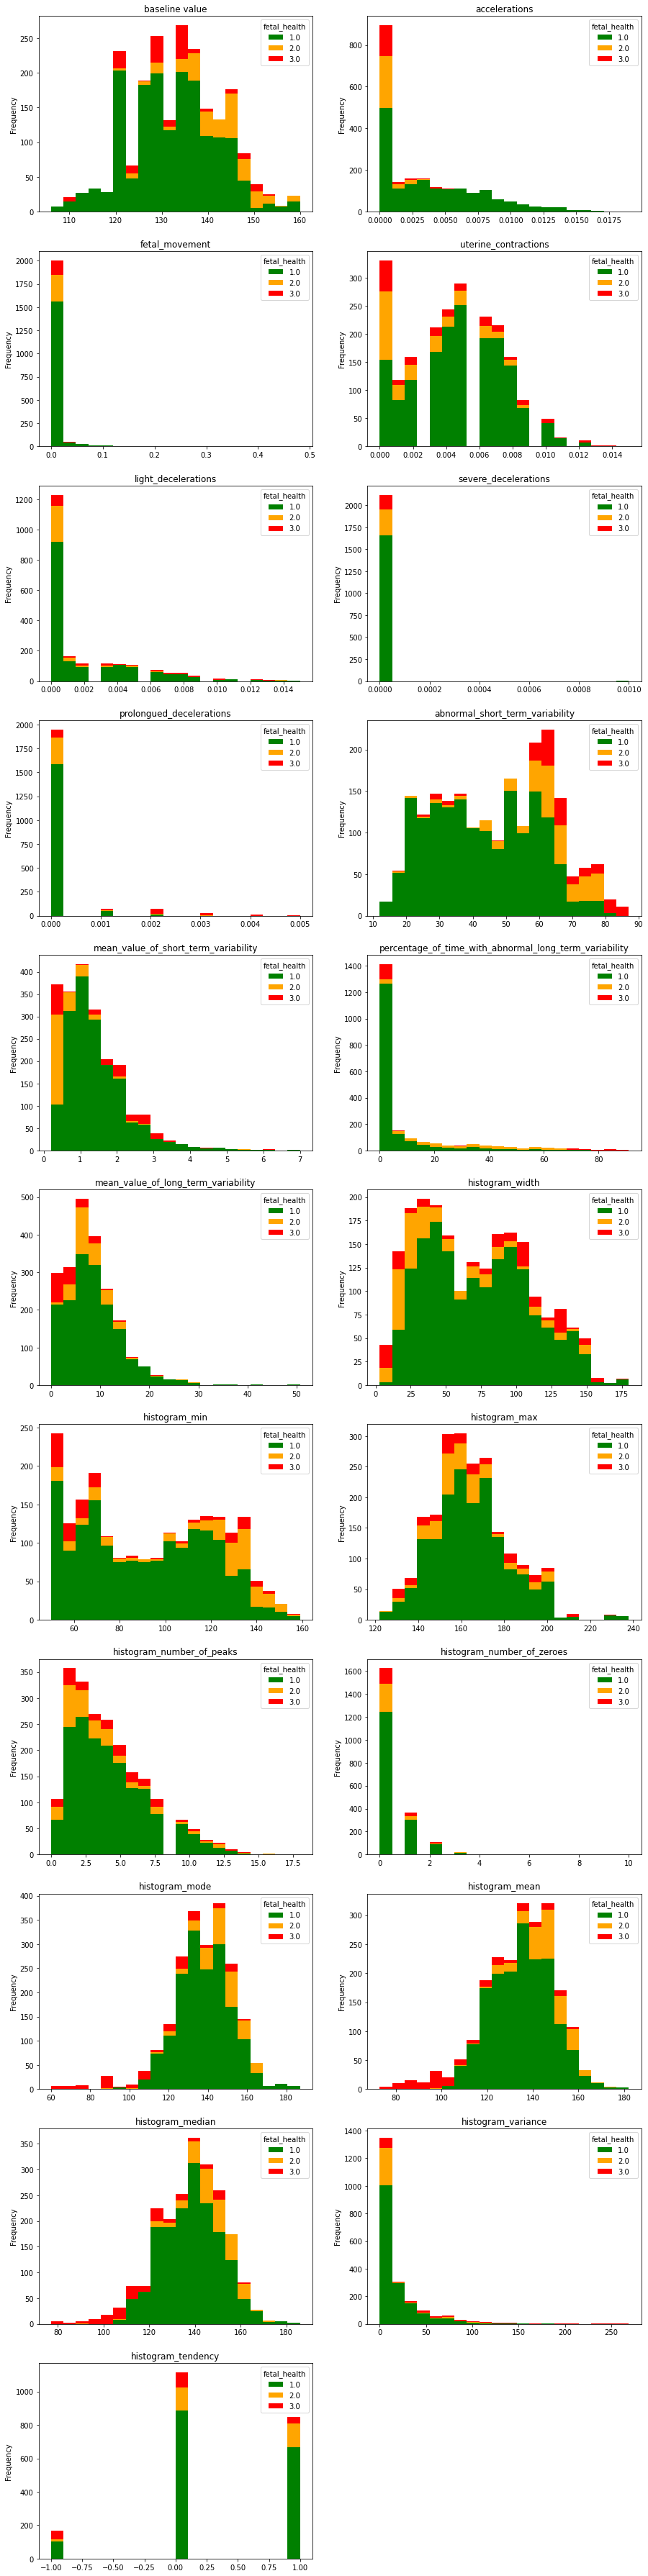

In [225]:
plt.figure(figsize=(15, 65))
for col, i in zip(data.columns[:-1], range(len(data.columns[:-1]))):
    data.pivot(columns="fetal_health")[col].plot.hist(
        bins=20, 
        stacked=True, 
        title=col, 
        ax=plt.subplot(11, 2, i+1),
        color=list(diagnosis_color_map.values())
    )

Calcoliamo la correlazione di ciascuna feature con ciascuna possibile diagnosi con il metodo Pearson

In [226]:
from sklearn.preprocessing import OneHotEncoder

In [227]:
encoder = OneHotEncoder(sparse = False)
target_variables = pd.DataFrame(
    encoder.fit_transform(data[["fetal_health"]]),
    columns=encoder.get_feature_names_out()
)

In [228]:
# target_variables

In [229]:
data_combo = data.join(target_variables)
data_combo.drop(columns=["fetal_health"])
data_combo

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,...,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,0.0,1.0,0.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,1.0,0.0,0.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,1.0,0.0,0.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,1.0,0.0,0.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,...,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0,0.0,1.0,0.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,...,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0,0.0,1.0,0.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,...,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0,0.0,1.0,0.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,...,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0,0.0,1.0,0.0


In [230]:
data_corr = data_combo.corr(method='pearson')

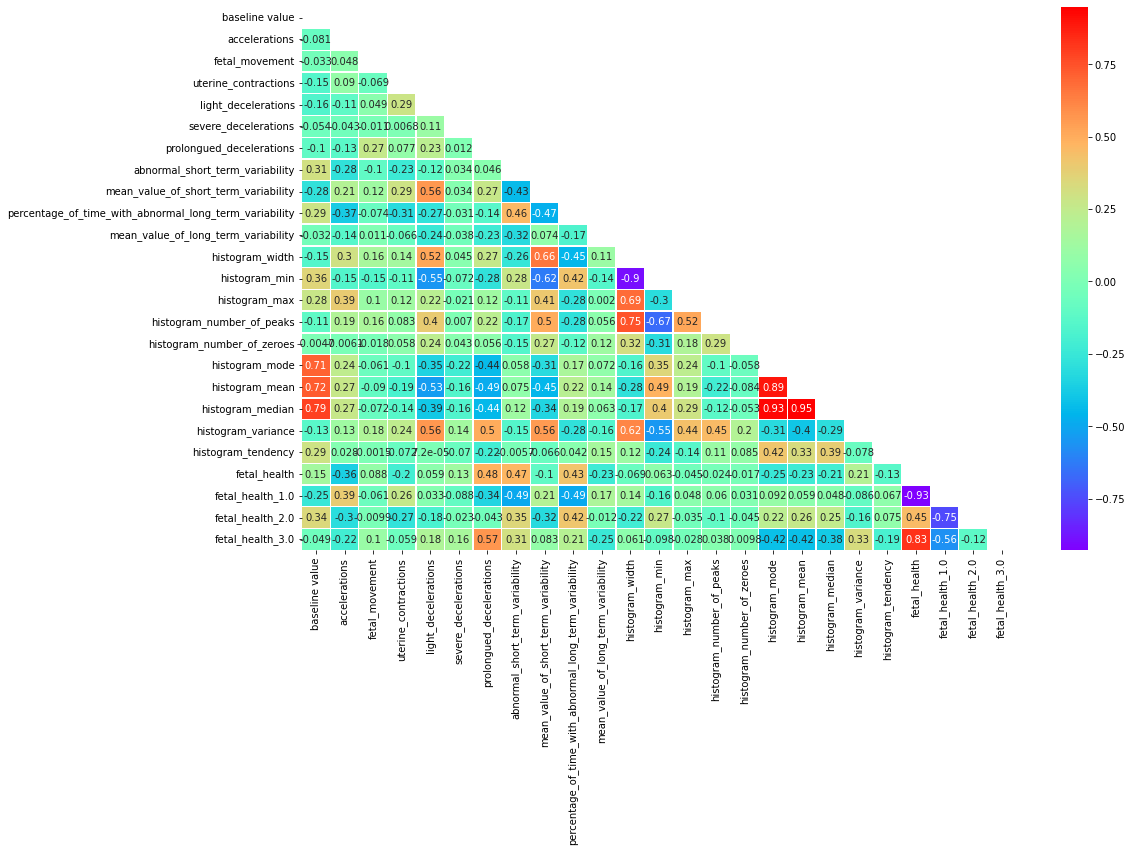

In [231]:
mask = np.zeros_like(data_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 10))
sns.heatmap(data_corr, mask=mask, cmap="rainbow", linewidths=0.30, annot=True)

In [232]:
x = data_corr[list(encoder.get_feature_names_out())].sort_values(
    list(encoder.get_feature_names_out()), ascending=False)
x = x.drop(list(encoder.get_feature_names_out()) + ["fetal_health"], axis=0)
x.style.background_gradient(cmap="rainbow")

,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
accelerations,0.394760,-0.301581,-0.216591
uterine_contractions,0.263639,-0.269365,-0.059397
mean_value_of_short_term_variability,0.207717,-0.315373,0.082600
mean_value_of_long_term_variability,0.172519,-0.011522,-0.245545
histogram_width,0.142182,-0.219384,0.060945
histogram_mode,0.092320,0.223125,-0.419051
histogram_tendency,0.066529,0.074653,-0.193919
histogram_number_of_peaks,0.060354,-0.102957,0.038205
histogram_mean,0.059107,0.261298,-0.416886
histogram_max,0.048106,-0.035153,-0.028399


Come era facile e logico aspettarsi, le _feature_ che hanno un'elevata correlazione con la classe `1`, Normale, hano una correlazione inversa con le altre due classi, Sospetto e Patologico, e viceversa.

Le _feature_ che hanno una maggior correlazione con la classe Normale sono:
- `accelerations` 
- `uterine_contractions`

Le _feature_ che hanno una maggior correlazione con la altre due classi sono:
- `prolongued_decelerations`
- `percentage_of_time_with_abnormal_long_term_variability`
- `abnormal_short_term_variability`
- `baseline value`

Infatti, rappresentando ad esempio la distribuzione congiunta di `abnormal_short_term_variability` e `percentage_of_time_with_abnormal_long_term_variability` in un grafico a dispersione si ottiene:

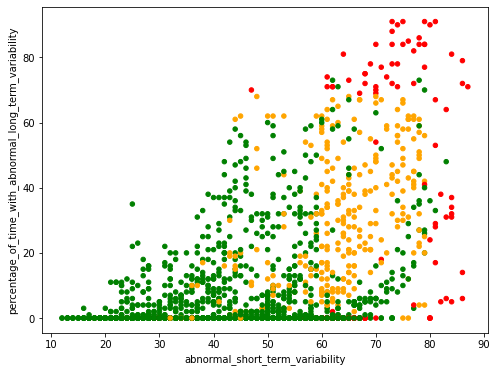

In [233]:
data.plot.scatter(
    "abnormal_short_term_variability", 
    "percentage_of_time_with_abnormal_long_term_variability", 
    c=diagnosis_colors, 
    figsize=(8, 6)
);

## Preparazione

### Valutazione dei modelli di classificazione

- **Accuratezza**: quanto il modello è efficace nel prevedere le classi corrette delle osservazioni. 
- Siccome il valore di accuratezza dipende dal _validation set_ che si utilizza, l'obiettivo è stimare un intervallo di valori in cui l'acuretezza reale del modello cade con una percentuale $p$ di probabilità. Tale percentuale è detto **livello di confidenza** e l'intervallo stimato è dtto **intervallo di confidenza**
- Intervallo di confidenza si calcola: $$ \frac{2Na+Z^2\pm Z\sqrt{Z^2+4Na+4Na^2}}{2(N+Z^2)} $$ dove:
    - $a$ è l'accuratezza del modello misurata sul validation set
    - N è il numero di osservazioni nel validation set
    - Z è il valore tale per cui l'area sottesa dalla densità di probabilità $\varphi(x)$ della distribuzione normale standard tra -Z e Z sia il livello di confidenza 1-𝛼. Con un livello di confidenza pari a 95%, $Z=1.96$. In generale tale valore lo s può ottenere in python con: 
    ```python
        from scipy.stats import norm
        norm.ppf(0.975)   # 1 - 0.05/2
    ```
- **Precision**: percentuale di esempi classificati come una classe `C` che sono realmente tali
- **Recall**: percentuale di esempi realmente di classe `C` che sono stati rilevati dall'algoritmo
- Un modo per visualizzare Precision e Recall è utilizzare la **Matrice di Confusione**: ogni colonna della matrice rappresenta i valori predetti, mentre ogni riga rappresenta i valori reali. L'elemento sulla riga $i$ e sulla colonna $j$ è il numero di casi in cui il classificatore ha classificato la classe "vera" $i$ come classe $j$.
- **_F1-measure_**: media armonica tra Precision e Recall

Definiamo alcune funzioni di supporto per calcolare e stampare a le statistiche di accuratezza.

In [234]:
def conf_interval(a, N, Z=1.96):
    '''
    Computes the confidence interval of a model, given its parameters.

        Parameters:
            a: model accuracy measured on validation set
            N: number of rows in the validation set
            Z: z distribution

        Returns:
            (a, b): tuple with the confidence interval.
    '''
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [235]:
def plot_confusion_matrix(confusion_matrix):
    '''
    Plot the confusion matrix given in input as an heatmap.
    '''
    sns.heatmap(confusion_matrix, cmap="Greens", annot=True)
    plt.xlabel('Classe **predetta**')
    plt.ylabel('Classe **reale**')
    plt.title("Confusion Matrix")

In [236]:
from sklearn.metrics import confusion_matrix, f1_score
def print_eval(X_val, y_val, model):
    '''
    Function to print prediction accuracy stats.
    '''
    print("++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++")
    score = model.score(X_val, y_val)
    print(f"> Score: {score:4.4f} ({score * 100: 5.2f}%)")
    print(f"\n> Intervallo accuratezza (confidenza 95%): {conf_interval(score, len(X_val))}")
    cf = pd.DataFrame(
        confusion_matrix(y_val, model.predict(X_val)), 
        index=model.classes_, 
        columns=model.classes_
    )
    print(f"\n> Confusion Matrix: \n{cf}")
    plot_confusion_matrix(cf)
    score_f1 = f1_score(y_val, model.predict(X_val), average=None)
    print(f"\n> f1_score per feature: \n{score_f1}")
    score_f1_agg = f1_score(y_val, model.predict(X_val), average="macro")
    print(f"\n> f1_score macro: {score_f1_agg:3.3f}")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

### Suddivisione dati 

Suddivido in training e validation set i dati.

In [237]:
X = data.drop(["fetal_health"], axis=1)
y = data["fetal_health"]

In [238]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,               # data to split
    test_size = 1/3,    # 2/3 training set, 1/3 validation set
    random_state = 42   # seed for reproducibility
)

In [239]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def get_tuned_model(model, params_grid, X_train, y_train):
    '''
    Create a stratified k-fold and find the best params with grid search.

        Parameters:
            model: the model to tune
            params_grid: the grid of parameters (dictionary)
            X_train: the training set with all the features
            y_train: the training set with the target feature to predict

        Returns:
            (gs, gs.best_params_, ranking): a tuple containing the fitted model, 
            a dictionary with the best results on the hod out data 
            and a dataframe containg the ranking of the top 5 parameters.
    '''
    skf = StratifiedKFold(5, shuffle=True)
    gs = GridSearchCV(model, params_grid, cv=skf)
    gs.fit(X_train, y_train)
    ranking = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)
    return gs, gs.best_params_, ranking

In [240]:
def get_features_scores(model):
    '''
    Computes and plots on a bar chart the features weight of the model 
    given in input.

        Parameters:
            model: the fitted model fro which extract the teh features score
        
        Returns:
            fs: a dataframe with the weigth of each feature
    '''
    fs = pd.DataFrame(
        model.best_estimator_[-1].coef_.T,
        columns=diagnosis_desc.values(), 
        index=X.columns
    )
    fs.plot.bar(figsize=(15,8), grid=True, stacked=True, width=.8)
    return fs

2 approcci:
- con `multi_class="ovr"` (_one versus rest_) per ciascuna classe C si addestra un modello indipendentemente dagli altri a distinguere "C" da "non C"
- con `multi_class="multinomial"` (default) viene calcolata e minimizzata un'unica funzione d'errore (con eventuale regolarizzazione) su tutti gli iperpiani

## Modelli 

Nel seguito verranno usati 5 algoritmi per classificare le istanze, basati su due famiglie differenti:
- Classificazione con iperpiani
    1. Perceptron
    2. Regressione logistica
    3. SVM
- Alberi decisionali
    4. DecisionTreeClassifier
    5. XGBoost

Gli ultimi due sfruttano gli alberi decisionali: creano una struttura ad albero tale da segmentare lo spazio mediante un insieme di regole (percorsi) che sfruttano le relazioni tra una classe e le variabili.

L'obiettivo dei primi tre è quello invece di individuare un iperpiano di separazione che massimizzi la separazione tra le classi. Per problemi di classificazione multi-classe (come nel nostro caso) vi sono 2 approcci:
- **One-Versus-All**: per ciascuna classe `C` si addestra un modello indipendente dagli altri a distinguere `C` da `non C`.
- **Multinomial**: viene calcolata e minimizzata un'unica funzione di errore su tutti gli iperpiani.

N.B. Non tutti gli algoritmi supportano entrambi i metodi!

In tutti i casi utilizzeremo la _cross validation_ a _$k$ fold_ per la validazione del modello e la _grid search_ per individuare la miglior combinazione di iper-parametri da utilizzare.
Un iper-parametro importante da sottolineare, comune a tutti gli algoritmi di classificazione, è `class_weight`, ovvero il peso da associare a ciascuna classe. Come già osservato nell'Analisi esplorativa dei dati, siccome siamo in presenza di una suddivisione sbilanciata delle istanze delle classi è opportuno aumentare il peso degli errori sulla classe con meno istanze.



---
[[Multiclass and multioutput algorithms documentation](https://scikit-learn.org/stable/modules/multiclass.html)]


### Perceptron

[[_Perceptron_ doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)]


---

_Perceptron_ è un algoritmo di classificazione molto semplice, concettualmente simile alla discesa del gradiente. 

**NOTA: _Percepetron_ usa la versione ONE-VERSUS-ALL**.


In [241]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Iperparametri:
- `penalty` (default=`None`): Tipo di regolarizzazione da usare => {`'l2'`,`'l1'`,`'elasticnet'`}
- `alpha` (default=`0.0001`): Costante che moltiplica il termine di regolarizzazione se usata ($\lambda$ nelle _slides_ di teoria)
- `l1_ratio` (default=`0.15`): Il parametro di proporzione della regolarizzazione _Elastic Net_: $0 \leq$ `l1_ratio` $\leq 1$. `l1_ratio=0` corrisponde a regolarizzazione L2, `l1_ratio=1` a L1. **Da usare solo quando `penalty='elasticnet'`**.
- `class_weight` (default=`none`): Pesi associati a ciascuna classe: `dict, {class_label: weight}` o `"balanced"`. Se non fornita tutte le classi hanno lo stesso peso 1. 
    > The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.
    




In [242]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("prc", Perceptron())
])

In [243]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "prc__penalty": ["none"],
        "prc__class_weight": ["none", "balanced"]
    },
    {
        "scaler": [None, StandardScaler()],
        "prc__penalty": ["l2", "l1"],
        "prc__alpha": np.logspace(-2, 2, 5),
        "prc__class_weight": ["none", "balanced"]
    },
    {
        "scaler": [None, StandardScaler()],
        "prc__penalty": ["elasticnet"],
        "prc__alpha": np.logspace(-2, 3, 6),
        "prc__l1_ratio": [0.2, 0.4, 0.6, 0.8],
        "prc__class_weight": ["none", "balanced"]
    }
]

In [244]:
%%time
perceptron, perceptron_best_params, perceptron_ranking = \
    get_tuned_model(perceptron_model, params_grid, X_train, y_train)

CPU times: user 7.19 s, sys: 48.7 ms, total: 7.24 s
Wall time: 7.25 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
350 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/p

I migliori parametri ottenuti sono:

In [245]:
perceptron_best_params

{'prc__class_weight': 'balanced',
 'prc__penalty': 'none',
 'scaler': StandardScaler()}

Le prime 5 combinazioni di parametri che danno miglior score:

In [246]:
perceptron_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prc__class_weight,param_prc__penalty,param_scaler,param_prc__alpha,param_prc__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.009871,0.000927,0.002081,0.000067,balanced,none,StandardScaler(),NaN,NaN,"{'prc__class_weight': 'balanced', 'prc__penalt...",0.862676,0.859155,0.826855,0.848057,0.879859,0.855320,0.017516,1
59,0.012980,0.001058,0.002327,0.000111,balanced,elasticnet,StandardScaler(),0.01,0.8,"{'prc__alpha': 0.01, 'prc__class_weight': 'bal...",0.845070,0.809859,0.855124,0.876325,0.823322,0.841940,0.023417,2
10,0.013281,0.004116,0.002515,0.000449,balanced,l1,None,0.01,NaN,"{'prc__alpha': 0.01, 'prc__class_weight': 'bal...",0.827465,0.876761,0.787986,0.840989,0.830389,0.832718,0.028433,3
18,0.011942,0.001501,0.002089,0.000108,balanced,l1,None,0.1,NaN,"{'prc__alpha': 0.1, 'prc__class_weight': 'bala...",0.838028,0.873239,0.840989,0.805654,0.805654,0.832713,0.025312,4
2,0.008835,0.001903,0.002049,0.000101,balanced,none,None,NaN,NaN,"{'prc__class_weight': 'balanced', 'prc__penalt...",0.799296,0.848592,0.862191,0.713781,0.826855,0.810143,0.052669,5


,normale,sospetto,patologico
baseline value,-2.326598,-20.159105,52.121149
accelerations,15.409805,-50.587723,-19.127004
fetal_movement,1.318835,-0.100599,5.608997
uterine_contractions,5.464164,-2.948533,-15.041397
light_decelerations,1.002623,3.760727,8.629465
severe_decelerations,-0.677036,-12.008540,20.183228
prolongued_decelerations,-8.198451,6.830917,27.853174
abnormal_short_term_variability,-7.210661,14.859836,38.730178
mean_value_of_short_term_variability,-1.513939,-0.593107,-18.639492
percentage_of_time_with_abnormal_long_term_variability,-0.916130,-0.811065,11.644709


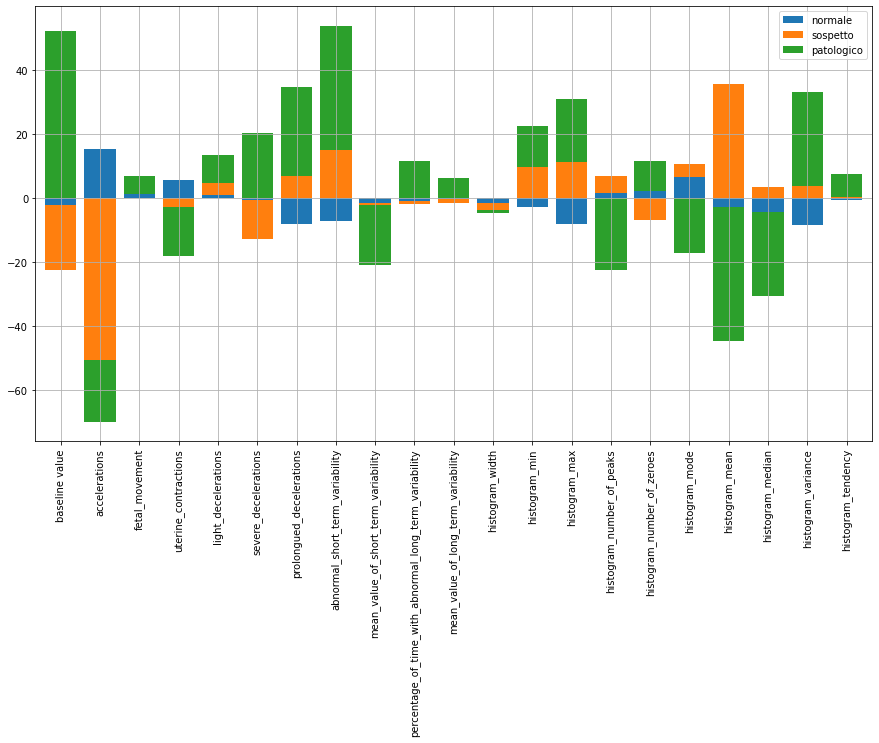

In [247]:
get_features_scores(perceptron)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8575 ( 85.75%)

> Intervallo accuratezza (confidenza 95%): (0.82988854984957, 0.8813494025931606)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  502   43   15
2.0   21   66   17
3.0    1    4   40

> f1_score per feature: 
[0.92619926 0.60829493 0.68376068]

> f1_score macro: 0.739
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


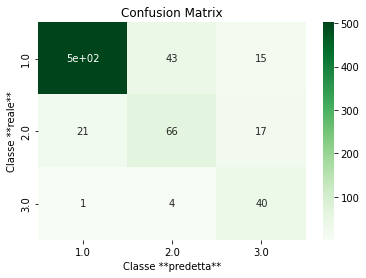

In [248]:
print_eval(X_val, y_val, perceptron)

### Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8],
        "lr__multi_class": ["ovr", "multinomial"]
    }
]

In [52]:
logistic_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga"))
])

In [53]:
# %%capture --no-display
%%time
logistic, logistic_best_params, logistic_ranking = \
    get_tuned_model(logistic_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

CPU times: user 1min 37s, sys: 513 ms, total: 1min 37s
Wall time: 1min 42s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [54]:
logistic_best_params

{'lr__multi_class': 'multinomial',
 'lr__penalty': 'none',
 'scaler': StandardScaler()}

In [55]:
logistic_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__multi_class,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
147,0.111894,0.003114,0.002827,0.000555,multinomial,elasticnet,StandardScaler(),1000.0,0.8,"{'lr__C': 1000.0, 'lr__l1_ratio': 0.8, 'lr__mu...",0.901408,0.866197,0.897527,0.883392,0.908127,0.89133,0.014945,1
49,0.082042,0.001980,0.002772,0.000542,multinomial,l2,StandardScaler(),1000.0,NaN,"{'lr__C': 1000.0, 'lr__multi_class': 'multinom...",0.901408,0.866197,0.897527,0.883392,0.908127,0.89133,0.014945,1
123,0.112198,0.005796,0.002931,0.000272,multinomial,elasticnet,StandardScaler(),100.0,0.4,"{'lr__C': 100.0, 'lr__l1_ratio': 0.4, 'lr__mul...",0.901408,0.866197,0.897527,0.883392,0.908127,0.89133,0.014945,1
51,0.109762,0.002945,0.002858,0.000542,multinomial,l1,StandardScaler(),1000.0,NaN,"{'lr__C': 1000.0, 'lr__multi_class': 'multinom...",0.901408,0.866197,0.897527,0.883392,0.908127,0.89133,0.014945,1
127,0.262386,0.157535,0.002968,0.000573,multinomial,elasticnet,StandardScaler(),100.0,0.6,"{'lr__C': 100.0, 'lr__l1_ratio': 0.6, 'lr__mul...",0.901408,0.866197,0.897527,0.883392,0.908127,0.89133,0.014945,1


,normale,sospetto,patologico
baseline value,-0.458202,-1.372854,1.831056
accelerations,1.867945,-1.931766,0.063821
fetal_movement,-0.431759,0.046788,0.384972
uterine_contractions,0.522515,-0.203493,-0.319022
light_decelerations,0.077932,-0.083100,0.005168
severe_decelerations,0.146780,-0.148002,0.001222
prolongued_decelerations,-0.867005,0.311438,0.555567
abnormal_short_term_variability,-1.383089,0.106256,1.276833
mean_value_of_short_term_variability,0.454670,0.316498,-0.771168
percentage_of_time_with_abnormal_long_term_variability,-0.452463,-0.121450,0.573912


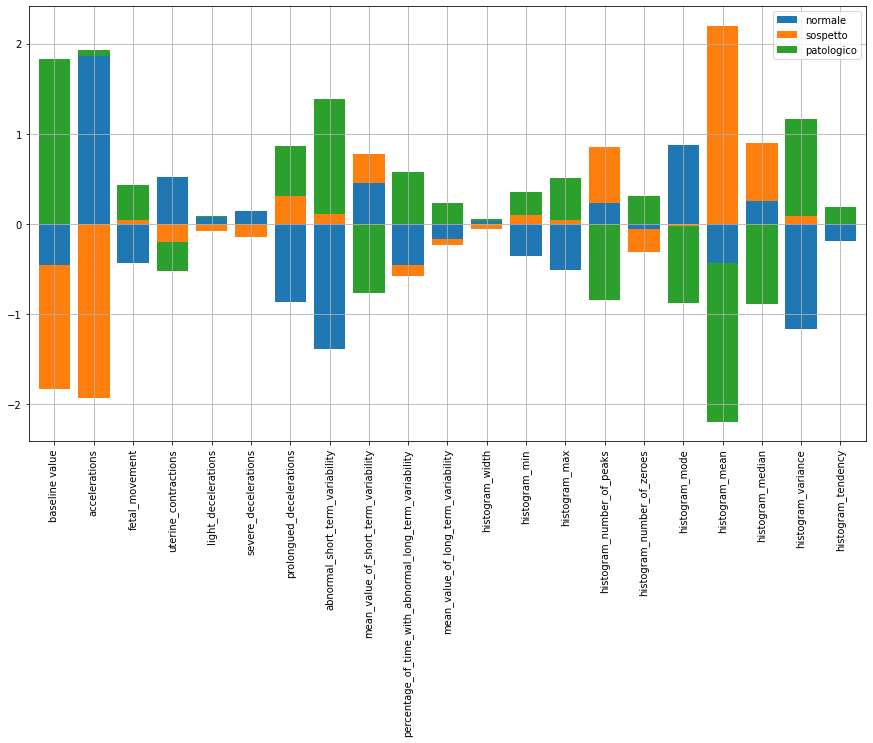

In [56]:
get_features_scores(logistic)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8858 ( 88.58%)

> Intervallo accuratezza (confidenza 95%): (0.8602307282042067, 0.9071206721629997)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  526   28    6
2.0   26   65   13
3.0    3    5   37

> f1_score per feature: 
[0.94349776 0.64356436 0.73267327]

> f1_score macro: 0.773
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


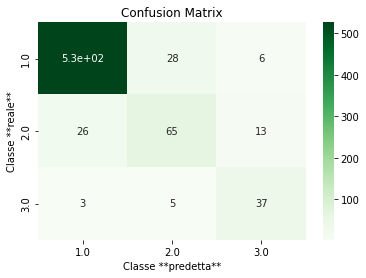

In [57]:
print_eval(X_val, y_val, logistic)

### SVM

In [58]:
from sklearn.svm import LinearSVC

In accordo con la documentazione: 
> **multi_class{‘ovr’, ‘crammer_singer’}, default=’ovr’**.
> 
> Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.

In [59]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l1"],
        "lr__C": np.logspace(-3, 3, 7),
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2"],
        "lr__C": np.logspace(-3, 3, 7),
    }
]

In [60]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearSVC(multi_class="ovr", dual=False))
])

In [61]:
svm, svm_best_params, svm_ranking = \
    get_tuned_model(svm_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

In [62]:
svm_best_params

{'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler': None}

In [63]:
svm_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.338731,0.006795,0.003331,0.000136,100.0,l1,None,"{'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...",0.897887,0.897887,0.893993,0.876325,0.886926,0.890604,0.008185,1
12,0.337338,0.003294,0.003226,0.000247,1000.0,l1,None,"{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...",0.890845,0.901408,0.893993,0.876325,0.886926,0.889899,0.008285,2
7,0.110951,0.007505,0.002346,0.000121,1.0,l1,StandardScaler(),"{'lr__C': 1.0, 'lr__penalty': 'l1', 'scaler': ...",0.890845,0.901408,0.901060,0.869258,0.886926,0.889899,0.011771,2
23,0.015836,0.001238,0.002683,0.000526,10.0,l2,StandardScaler(),"{'lr__C': 10.0, 'lr__penalty': 'l2', 'scaler':...",0.887324,0.904930,0.897527,0.869258,0.886926,0.889193,0.012026,4
9,0.185546,0.023097,0.002982,0.000519,10.0,l1,StandardScaler(),"{'lr__C': 10.0, 'lr__penalty': 'l1', 'scaler':...",0.887324,0.904930,0.897527,0.869258,0.886926,0.889193,0.012026,4


,normale,sospetto,patologico
baseline value,-0.008574,-0.011191,0.029080
accelerations,238.352271,-225.711288,-124.870596
fetal_movement,-2.049902,0.853273,3.487915
uterine_contractions,77.090383,-57.226486,-51.253629
light_decelerations,6.398095,-9.403899,14.638925
severe_decelerations,0.000000,0.000000,0.000000
prolongued_decelerations,-643.411177,0.000000,445.153142
abnormal_short_term_variability,-0.027634,0.014016,0.031040
mean_value_of_short_term_variability,0.147928,-0.023176,-0.179175
percentage_of_time_with_abnormal_long_term_variability,-0.007984,0.000266,0.014414


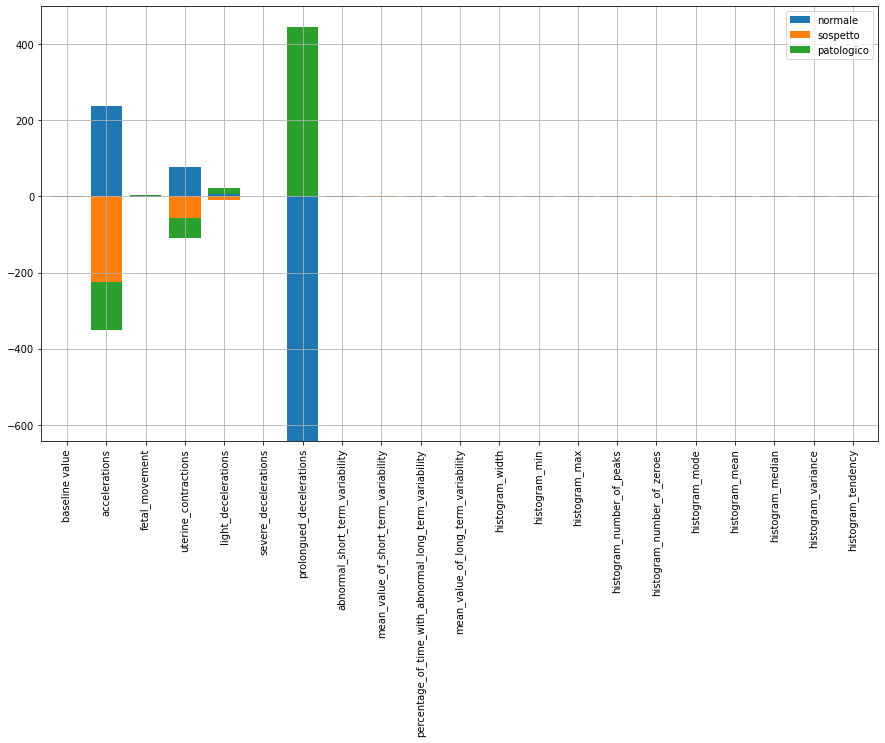

In [64]:
get_features_scores(svm)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8914 ( 89.14%)

> Intervallo accuratezza (confidenza 95%): (0.8663487486993131, 0.9122253412527885)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  531   23    6
2.0   30   65    9
3.0    4    5   36

> f1_score per feature: 
[0.944      0.65989848 0.75      ]

> f1_score macro: 0.785
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


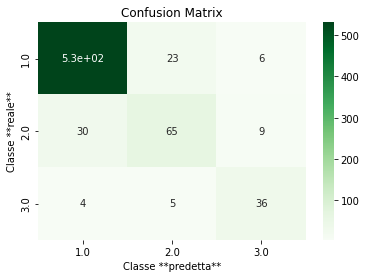

In [65]:
print_eval(X_val, y_val, svm)

### Alberi decisionali

In [66]:
from sklearn.tree import DecisionTreeClassifier

In [67]:
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

In [68]:
params_grid = {
    "tree__max_depth": [2, 4, 6, 8, 10],
    "tree__min_samples_leaf": np.arange(1, 10),
    "tree__min_samples_split": np.arange(2, 20, 2)
}

In [69]:
tree, tree_best_params, tree_ranking = \
    get_tuned_model(tree_model, params_grid, X_train, y_train)

In [70]:
tree_best_params

{'tree__max_depth': 8,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 14}

In [71]:
tree_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
258,0.013527,0.002232,0.003013,0.000604,8,2,14,"{'tree__max_depth': 8, 'tree__min_samples_leaf...",0.929577,0.897887,0.915194,0.911661,0.929329,0.916730,0.011890,1
339,0.012050,0.000376,0.002255,0.000063,10,2,14,"{'tree__max_depth': 10, 'tree__min_samples_lea...",0.922535,0.904930,0.915194,0.904594,0.929329,0.915316,0.009709,2
335,0.012359,0.000629,0.002336,0.000205,10,2,6,"{'tree__max_depth': 10, 'tree__min_samples_lea...",0.922535,0.904930,0.911661,0.911661,0.925795,0.915316,0.007701,2
259,0.011087,0.000131,0.002174,0.000076,8,2,16,"{'tree__max_depth': 8, 'tree__min_samples_leaf...",0.929577,0.897887,0.908127,0.908127,0.932862,0.915316,0.013553,4
268,0.011761,0.001545,0.002138,0.000083,8,3,16,"{'tree__max_depth': 8, 'tree__min_samples_leaf...",0.926056,0.904930,0.904594,0.908127,0.932862,0.915314,0.011813,5


La funzione `get_features_scores(tree)` non funziona :(

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.9252 ( 92.52%)

> Intervallo accuratezza (confidenza 95%): (0.9035130911290574, 0.9423971363324151)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  533   22    5
2.0   24   79    1
3.0    1    0   44

> f1_score per feature: 
[0.95348837 0.77073171 0.92631579]

> f1_score macro: 0.884
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


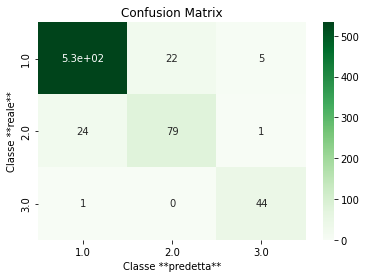

In [72]:
print_eval(X_val, y_val, tree)

### XGBoost

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [73]:
import xgboost
from xgboost import XGBClassifier

In [74]:
xgb_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(nthread=8, objective="multi:softprob"))
])

In [75]:
params_grid = {
    'xgb__eta': [0.002, 0.1, 0.5],
    'xgb__max_depth': [6],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

In [76]:
%%time
xgb, xgb_best_params, xgb_ranking = \
    get_tuned_model(xgb_model, params_grid, X_train, y_train)

CPU times: user 3min 12s, sys: 40.2 s, total: 3min 52s
Wall time: 2min 6s


In [77]:
xgb_best_params

{'xgb__alpha': 0.0001,
 'xgb__eta': 0.002,
 'xgb__max_depth': 6,
 'xgb__n_estimators': 300}

In [78]:
xgb_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__alpha,param_xgb__eta,param_xgb__max_depth,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.556330,0.033801,0.012665,0.003176,0.0001,0.002,6,300,"{'xgb__alpha': 0.0001, 'xgb__eta': 0.002, 'xgb...",0.943662,0.961268,0.954064,0.918728,0.943463,0.944237,0.01441,1
3,2.542337,0.051537,0.010871,0.000361,0.0001,0.1,6,300,"{'xgb__alpha': 0.0001, 'xgb__eta': 0.1, 'xgb__...",0.943662,0.961268,0.954064,0.918728,0.943463,0.944237,0.01441,1
5,2.547175,0.043741,0.011549,0.000486,0.0001,0.5,6,300,"{'xgb__alpha': 0.0001, 'xgb__eta': 0.5, 'xgb__...",0.943662,0.961268,0.954064,0.918728,0.943463,0.944237,0.01441,1
7,2.513512,0.050388,0.011370,0.000180,0.001,0.002,6,300,"{'xgb__alpha': 0.001, 'xgb__eta': 0.002, 'xgb_...",0.943662,0.961268,0.954064,0.918728,0.943463,0.944237,0.01441,1
9,2.511746,0.053100,0.011683,0.001033,0.001,0.1,6,300,"{'xgb__alpha': 0.001, 'xgb__eta': 0.1, 'xgb__m...",0.943662,0.961268,0.954064,0.918728,0.943463,0.944237,0.01441,1


++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.9492 ( 94.92%)

> Intervallo accuratezza (confidenza 95%): (0.9305059638918175, 0.9631006943054595)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  544   13    3
2.0   17   85    2
3.0    1    0   44

> f1_score per feature: 
[0.96969697 0.84158416 0.93617021]

> f1_score macro: 0.916
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


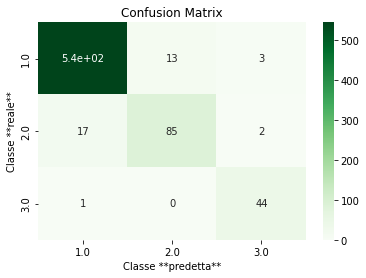

In [79]:
print_eval(X_val, y_val, xgb)

## CLASSIFICAZIONE NON LINEARE

In [80]:
from sklearn.preprocessing import PolynomialFeatures

In [81]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "poly__degree" : [2, 3],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "poly__degree" : [2, 3],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "poly__degree" : [2, 3],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8],
        "lr__multi_class": ["ovr", "multinomial"]
    }
]

In [82]:
poly_logistic_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LogisticRegression(solver="saga"))
])

In [83]:
%%time
poly_logistic, poly_logistic_best_params, poly_logistic_ranking = \
    get_tuned_model(poly_logistic_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

KeyboardInterrupt: ignored

## Confronto tra modelli

In [84]:
from scipy.stats import norm

In [85]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [86]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1+level) / 2)
    return diff_interval(a1, a2, N, N, Z)

In [ ]:
model_names = ["perceptron", "logistic", "poly_logistic", "svm", "tree", "xgb"]
models = [perceptron, logistic, poly_logistic, svm, tree, xgb]
n_models = len(models)

In [ ]:
scores = np.empty((n_models, n_models), dtype=object)
for m1, i in zip(models, range(n_models)):
    for m2, j in zip(models, range(n_models)):
        scores[i, j] = model_diff_interval(m1, m2, X_val, y_val)
scores = np.where(np.tril(scores, -1) == 0, 0, scores)
scores = pd.DataFrame(scores, columns=model_names, index=model_names)

In [ ]:
scores